In [3]:
import pm4py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from datetime import datetime
from datetime import timedelta
import pickle
import itertools

parsing log, completed traces ::   0%|          | 0/2315 [00:00<?, ?it/s]

In [5]:
sites_pth = 'Source/Data/sites'
cdl_pth = 'Source/Data/cdl'
eventlog_pth = 'Event_log/148sites_240129.xes'

if __name__ == "__main__":
    log = pm4py.read_xes(eventlog_pth)

log['doy']=[x.dayofyear for x in log['Timestamp']]
log['Year']=[str(x.year) for x in log['Timestamp']]

tsL=[]
for i in np.arange(0,148,1):
    #loading data
    sid=i
    ts=pd.read_hdf(sites_pth+f'/Site{sid:03}_NBARint.h5')
    ts['doy']=ts.index.dayofyear
    tsL.append(ts)
#cleaning according to CDL
def warn_mark(i,n):
    return f"{i:04}_{n+2007}"
def warn_site_years(Lst):
    threshold=np.nonzero(np.array(Lst[1])<0.75)[0]
    return list(map(lambda x: warn_mark(Lst[0], x), threshold))

with open(cdl_pth+"/ConsistencyPerc", "rb") as fp:   # Unpickling
    site_consistencyL = pickle.load(fp)

CaseID_anom=list(map(warn_site_years, enumerate(site_consistencyL)))
flat_CaseID_anom = list(itertools.chain.from_iterable(CaseID_anom))
flt_log=pm4py.filtering.filter_event_attribute_values(log, 'CaseID', flat_CaseID_anom,retain=False)

In [4]:
#source usda field crops usual planting and harvesting --idaho
#https://downloads.usda.library.cornell.edu/usda-esmis/files/vm40xr56k/dv13zw65p/w9505297d/planting-10-29-2010.pdf
potato_usual=[[pd.Timestamp(2009, 4, 6).dayofyear,pd.Timestamp(2009, 6, 9).dayofyear]
              ,[pd.Timestamp(2009, 8, 15).dayofyear,pd.Timestamp(2009, 10, 27).dayofyear]]

alfalfa_usual=[[0,0]
               ,[pd.Timestamp(2009, 5, 22).dayofyear,pd.Timestamp(2009, 10, 20).dayofyear]]

sugarbeets_usual=[[pd.Timestamp(2009, 3, 24).dayofyear,pd.Timestamp(2009, 5, 5).dayofyear]
                  ,[pd.Timestamp(2009, 9, 15).dayofyear,pd.Timestamp(2009, 11, 10).dayofyear]]

springwheat_usual=[[pd.Timestamp(2009, 3, 21).dayofyear,pd.Timestamp(2009, 5, 26).dayofyear]
                   ,[pd.Timestamp(2009, 8, 4).dayofyear,pd.Timestamp(2009, 9, 29).dayofyear]]

winterwheat_usual=[[pd.Timestamp(2008, 9, 8).dayofyear,pd.Timestamp(2008, 11, 3).dayofyear]
                   ,[pd.Timestamp(2009, 7, 23).dayofyear,pd.Timestamp(2009, 9, 14).dayofyear]]

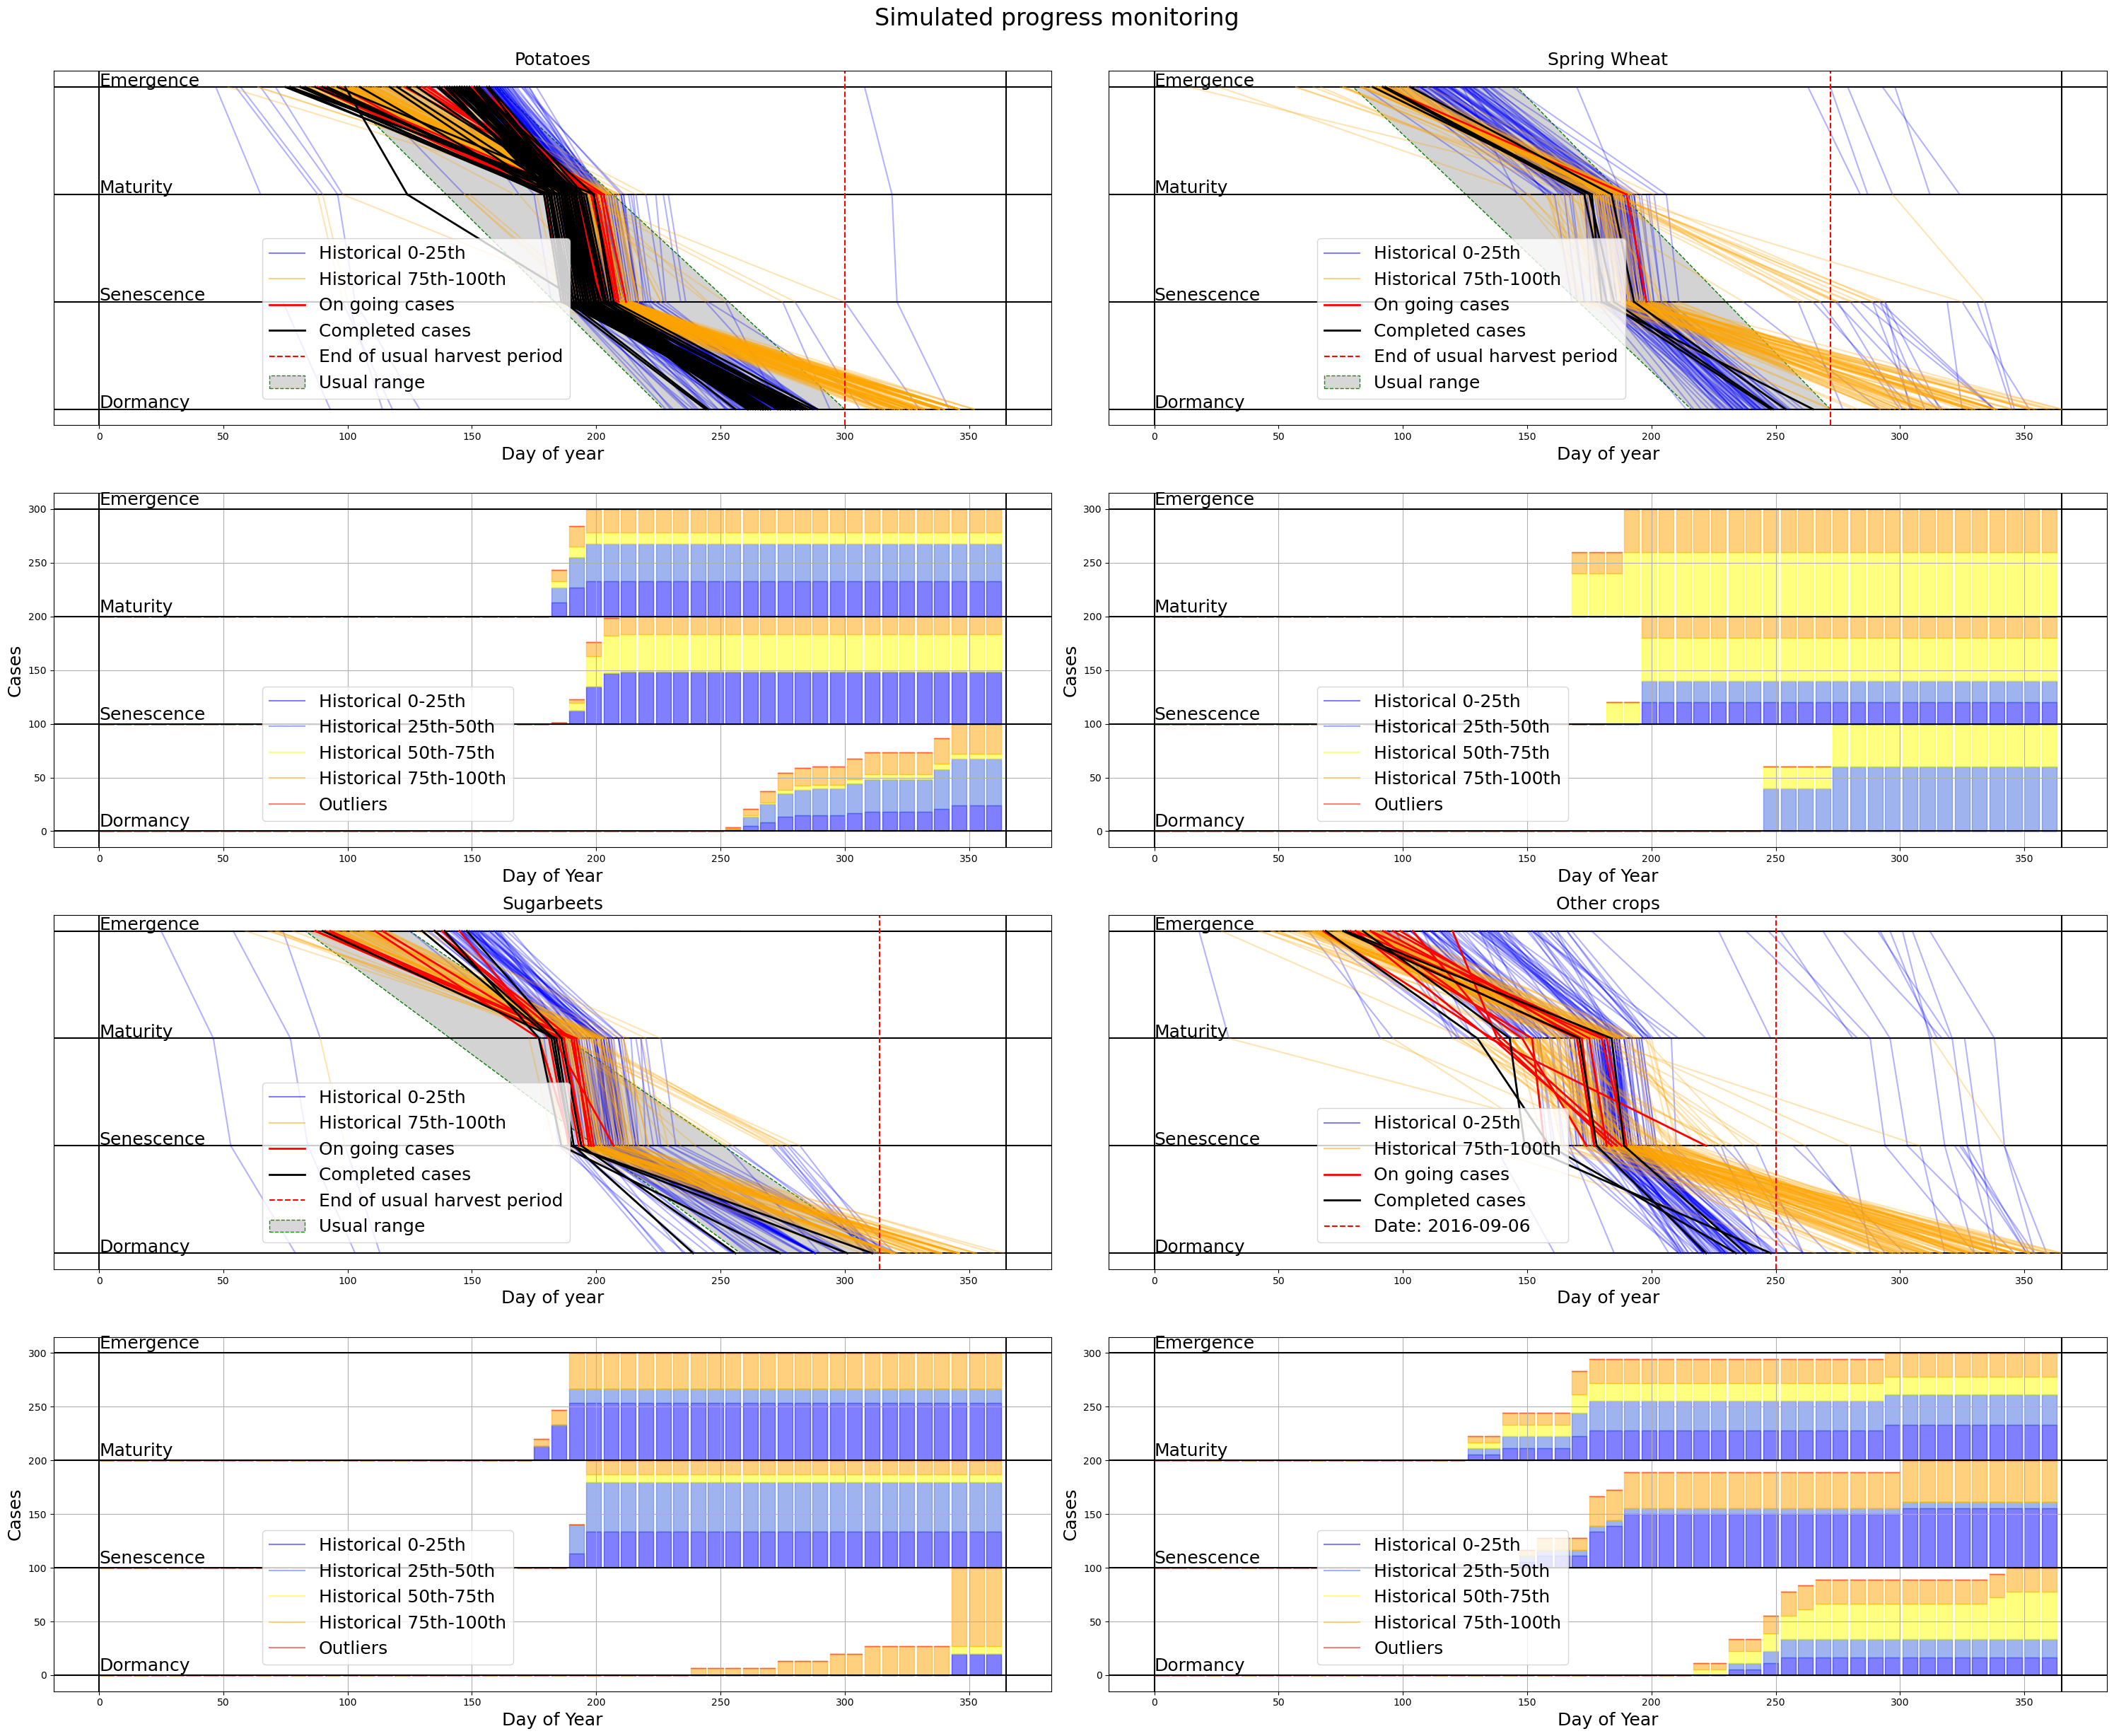

In [33]:
def plot_ps_separate_ax(LG, axi, ci=None, title='', cutoff=None, plotquartiles=[True,True,True,True]):
    yt='2016'

    ax[axi].axhline(y=0,color='k')
    ax[axi].axhline(y=400,color='k')
    ax[axi].axhline(y=800,color='k')
    ax[axi].axhline(y=1200,color='k')
    ax[axi].axvline(x=0,color='k')
    ax[axi].axvline(x=365,color='k')
    ax[axi].text(0, 4, 'Dormancy', fontsize=18, color='k')
    ax[axi].text(0, 404, 'Senescence', fontsize=18, color='k')   
    ax[axi].text(0, 804, 'Maturity', fontsize=18, color='k')
    ax[axi].text(0, 1204, 'Emergence', fontsize=18, color='k')
    def sub_ps(em,ma,se,do, axi, cutoff=None):

        def inplot(em,ma,se,do, cmap, alpha=0.5, linewidth=1):
            for i in np.argsort(ma-em):
                x=[em[i],ma[i]]
                y=[1200,800]
                ax[axi].plot(x, y,color=cmap, alpha=alpha, linewidth=linewidth)

            for i in np.argsort(se-ma):
                x=[ma[i],se[i]]
                y=[800,400]
                ax[axi].plot(x, y,color=cmap, alpha=alpha, linewidth=linewidth)

            for i in np.argsort(do-se):
                x=[se[i],do[i]]
                y=[400,0]
                ax[axi].plot(x, y,color=cmap, alpha=alpha,  linewidth=linewidth)
        if cutoff:
            if cutoff=='usual_harvest_end':
                cutoff=usuals[ci][1,1]
            em=np.where(em<cutoff, em, np.nan)
            ma=np.where(ma<cutoff, ma, np.nan)
            se=np.where(se<cutoff, se, np.nan)
            do=np.where(do<cutoff, do, np.nan)
            ax[axi].axvline(x=cutoff,color='r', linestyle='--')
            incomplete=np.isnan(do)
            inplot(em[incomplete],ma[incomplete],se[incomplete],do[incomplete], 'r', 1,2)
            complete=~incomplete
            inplot(em[complete],ma[complete],se[complete],do[complete], 'k', 1,2)
        else:
            inplot(em,ma,se,do, 'k',1,2)
    def hist_ps(em,ma,se,do, axi, plotquartiles):
        quartiles=[0,0.25,0.5,0.75,1]
        num_cases=len(em)
        loc=[int(np.rint(x * num_cases)) for x in quartiles]

        colors=['blue','royalblue','yellow','orange']
        allqctlist=[]
        def inplot(em,ma,se,do, pctj1, pctj2, cmap, alpha=0.5, plotquartile=False):
            qctlist=[]
            for i in np.argsort(ma-em)[pctj1:pctj2]:
                x=[em[i],ma[i]]
                y=[1200,800]
                if plotquartile:
                    ax[axi].plot(x, y,color=cmap, alpha=alpha)
            qctlist.append(ma[i]-em[i])
            for i in np.argsort(se-ma)[pctj1:pctj2]:
                x=[ma[i],se[i]]
                y=[800,400]
                if plotquartile:
                    ax[axi].plot(x, y,color=cmap, alpha=alpha)
            qctlist.append(se[i]-ma[i])
            for i in np.argsort(do-se)[pctj1:pctj2]:
                x=[se[i],do[i]]
                y=[400,0]
                if plotquartile:
                    ax[axi].plot(x, y,color=cmap, alpha=alpha)
            qctlist.append(do[i]-se[i])
            return qctlist
        for j,c in zip(range(4), colors):
            allqctlist.append(inplot(em, ma, se, do, loc[j], loc[j+1], c, 0.3, plotquartiles[j]))
        return allqctlist



    em=np.array(LG[LG['Activity']=='Emergence']['doy'])
    ma=np.array(LG[LG['Activity']=='Maturity']['doy'])
    se=np.array(LG[LG['Activity']=='Senescence']['doy'])
    do=np.array(LG[LG['Activity']=='Dormancy']['doy'])
    allqctlist=hist_ps(em,ma,se,do, axi, plotquartiles)
    
    yt_LG=LG[LG['Year']==yt]

    em=np.array(yt_LG[yt_LG['Activity']=='Emergence']['doy'])
    ma=np.array(yt_LG[yt_LG['Activity']=='Maturity']['doy'])
    se=np.array(yt_LG[yt_LG['Activity']=='Senescence']['doy'])
    do=np.array(yt_LG[yt_LG['Activity']=='Dormancy']['doy'])
    sub_ps(em,ma,se,do, axi, cutoff)
    if title=='Other crops':
        if cutoff:
            legend_elements = []
            if plotquartiles[0]:
                legend_elements+=[Line2D([0], [0], color='blue', alpha=0.5, label='Historical 0-25th')]
            if plotquartiles[1]:
                legend_elements+=[Line2D([0], [0], color='royalblue', alpha=0.5, label='Historical 25th-50th')]
            if plotquartiles[2]:
                legend_elements+=[Line2D([0], [0], color='yellow', alpha=0.5, label='Historical 50th-75th')]
            if plotquartiles[3]:
                legend_elements+=[Line2D([0], [0], color='orange', alpha=0.5, label='Historical 75th-100th')]
            legend_elements+=[
                Line2D([0], [0], color='r',linewidth=2, alpha=1, label='On going cases'),
                Line2D([0], [0],color='k',linewidth=2, alpha=1, label='Completed cases'),
                Line2D([0], [0],color='r', linestyle='--', label='Date: '+(datetime(int(yt), 1, 1) + timedelta(250 - 1)).strftime("%Y-%m-%d"))
            ]
        else:
            legend_elements = []
            if plotquartiles[0]:
                legend_elements+=[Line2D([0], [0], color='blue', alpha=0.5, label='Historical 0-25th')]
            if plotquartiles[1]:
                legend_elements+=[Line2D([0], [0], color='royalblue', alpha=0.5, label='Historical 25th-50th')]
            if plotquartiles[2]:
                legend_elements+=[Line2D([0], [0], color='yellow', alpha=0.5, label='Historical 50th-75th')]
            if plotquartiles[3]:
                legend_elements+=[Line2D([0], [0], color='orange', alpha=0.5, label='Historical 75th-100th')]
            legend_elements+=[Line2D([0], [0], color='k',linewidth=2, alpha=1, label='Year: '+yt)]
            
    else:
        if cutoff:
            legend_elements = []
            if plotquartiles[0]:
                legend_elements+=[Line2D([0], [0], color='blue', alpha=0.5, label='Historical 0-25th')]
            if plotquartiles[1]:
                legend_elements+=[Line2D([0], [0], color='royalblue', alpha=0.5, label='Historical 25th-50th')]
            if plotquartiles[2]:
                legend_elements+=[Line2D([0], [0], color='yellow', alpha=0.5, label='Historical 50th-75th')]
            if plotquartiles[3]:
                legend_elements+=[Line2D([0], [0], color='orange', alpha=0.5, label='Historical 75th-100th')]
            legend_elements+=[
                Line2D([0], [0], color='r',linewidth=2, alpha=1, label='On going cases'),
                Line2D([0], [0],color='k',linewidth=2, alpha=1, label='Completed cases')]
            if cutoff=='usual_harvest_end':
                legend_elements+=[Line2D([0], [0],color='r', linestyle='--', label='End of usual harvest period')]
            else:
                legend_elements+=[Line2D([0], [0],color='r', linestyle='--', label='Date: '+(datetime(int(yt), 1, 1) + timedelta(250 - 1)).strftime("%Y-%m-%d"))]
            legend_elements+=[Patch(facecolor='lightgrey', alpha=0.9, edgecolor='g', linestyle='--',label='Usual range')]
        else:
            legend_elements = []
            if plotquartiles[0]:
                legend_elements+=[Line2D([0], [0], color='blue', alpha=0.5, label='Historical 0-25th')]
            if plotquartiles[1]:
                legend_elements+=[Line2D([0], [0], color='royalblue', alpha=0.5, label='Historical 25th-50th')]
            if plotquartiles[2]:
                legend_elements+=[Line2D([0], [0], color='yellow', alpha=0.5, label='Historical 50th-75th')]
            if plotquartiles[3]:
                legend_elements+=[Line2D([0], [0], color='orange', alpha=0.5, label='Historical 75th-100th')]
            legend_elements+=[
                Line2D([0], [0], color='k',linewidth=2, alpha=1, label='Year: '+yt),
                Patch(facecolor='lightgrey', alpha=0.9, edgecolor='g', linestyle='--',label='Usual range')
            ]
    ax[axi].legend(handles=legend_elements, loc='lower left', bbox_to_anchor=(0.2, 0.05), ncol=1, fontsize=18)
    
    if ci!=None:
        ax[axi].fill_between(usuals[ci].T.flatten(), [1200,1200,1200,0],[1200,0,0,0], color='lightgrey', edgecolor='g', linestyle='--')
    ax[axi].get_yaxis().set_visible(False)
    ax[axi].set_xlabel('Day of year', fontsize=18, color='k')
    ax[axi].set_title(title, fontsize=18)
 
    #plot time series
    axi+=2
    num_cases=len(em)
    ax[axi].axhline(y=0,color='k')
    ax[axi].axhline(y=100,color='k')
    ax[axi].axhline(y=100*2,color='k')
    ax[axi].axhline(y=100*3,color='k')
    ax[axi].axvline(x=0,color='k')
    ax[axi].axvline(x=365,color='k')
    ax[axi].text(0, 4, 'Dormancy', fontsize=18, color='k')
    ax[axi].text(0, 100+4, 'Senescence', fontsize=18, color='k')   
    ax[axi].text(0, 100*2+4, 'Maturity', fontsize=18, color='k')
    ax[axi].text(0, 100*3+4, 'Emergence', fontsize=18, color='k')


    def aggregation(em,ma,se,do,allqctlist):
        emmaL=np.zeros((365,5))
        maseL=np.zeros((365,5))
        sedoL=np.zeros((365,5))

        for j in range(5):
            
            maem=ma-em
            sema=se-ma
            dose=do-se
            allqctlist.append([np.nanmax(maem),np.nanmax(sema),np.nanmax(dose)])
            if j!=0:
                j0=j-1
                for i in np.argsort(maem[(allqctlist[j0][0]<maem)&(maem<=allqctlist[j][0])]):
                    emmaL[ma[i]:,j]+=1
                for i in np.argsort(sema[(allqctlist[j0][1]<sema)&(sema<=allqctlist[j][1])]):
                    maseL[se[i]:,j]+=1
                for i in np.argsort(dose[(allqctlist[j0][2]<dose)&(dose<=allqctlist[j][2])]):
                    sedoL[do[i]:,j]+=1
            else:
                for i in np.argsort(maem[(maem<=allqctlist[j][0])]):
                    emmaL[ma[i]:,j]+=1
                for i in np.argsort(sema[(sema<=allqctlist[j][1])]):
                    maseL[se[i]:,j]+=1
                for i in np.argsort(dose[(dose<=allqctlist[j][2])]):
                    sedoL[do[i]:,j]+=1
        return emmaL, maseL, sedoL
    
    emmaL,maseL,sedoL=aggregation(em,ma,se,do,allqctlist)

    
    def window_pct(Lst,w0,w1,y_lower):
        ylow=np.zeros(7)+y_lower
        fst=np.zeros(7)+(y_lower+Lst[w1,0])
        snd=np.zeros(7)+(y_lower+Lst[w1,0]+Lst[w1,1])
        trd=np.zeros(7)+(y_lower+Lst[w1,0]+Lst[w1,1]+Lst[w1,2])
        fth=np.zeros(7)+(y_lower+Lst[w1,0]+Lst[w1,1]+Lst[w1,2]+Lst[w1,3])
        sth=np.zeros(7)+(y_lower+Lst[w1,0]+Lst[w1,1]+Lst[w1,2]+Lst[w1,3]+Lst[w1,4])
        ax[axi].fill_between(np.arange(w0,w1,1),fst,ylow,alpha=0.5, color='blue')
        ax[axi].fill_between(np.arange(w0,w1,1),snd,fst,alpha=0.5, color='royalblue')
        ax[axi].fill_between(np.arange(w0,w1,1),trd,snd,alpha=0.5, color='yellow')
        ax[axi].fill_between(np.arange(w0,w1,1),fth,trd,alpha=0.5, color='orange')
        ax[axi].fill_between(np.arange(w0,w1,1),sth,fth,alpha=0.5, color='red')
    for wi in np.arange(0,364,7):
        window_pct(emmaL*100/num_cases,wi,wi+7,200)
        window_pct(maseL*100/num_cases,wi,wi+7,100)
        window_pct(sedoL*100/num_cases,wi,wi+7,0)
    legend_elements = [
        Line2D([0], [0], color='blue', alpha=0.5, label='Historical 0-25th'),
        Line2D([0], [0], color='royalblue', alpha=0.5, label='Historical 25th-50th'),
        Line2D([0], [0], color='yellow', alpha=0.5, label='Historical 50th-75th'),
        Line2D([0], [0], color='orange', alpha=0.5, label='Historical 75th-100th'),
        Line2D([0], [0], color='red', alpha=0.5, label='Outliers'),
    ]
    ax[axi].legend(handles=legend_elements, loc='lower left', bbox_to_anchor=(0.2, 0.05), ncol=1, fontsize=18)
    ax[axi].set_ylabel('Cases',fontsize=18)
    ax[axi].set_xlabel('Day of Year',fontsize=18)  
    ax[axi].grid()

crops=['Potatoes', 'Spring Wheat', 'Sugarbeets']
usuals=[np.array(potato_usual), np.array(springwheat_usual), np.array(sugarbeets_usual)]
historical_quartiles=[True,False,False,True]
fig, ax = plt.subplots(4, 2, figsize=(30, 25))
ax=ax.flatten()
plt.suptitle('Simulated progress monitoring',fontsize=24)#\n'+(datetime(2016, 1, 1) + timedelta(250 - 1)).strftime("%Y-%m-%d"),fontsize=24)
ci=0
for i,c in zip([0,1,4,5],crops):
    cp_log=pm4py.filtering.filter_event_attribute_values(flt_log, 'Crop', [c])
    plot_ps_separate_ax(cp_log, i, ci, c, 'usual_harvest_end',historical_quartiles)
    ci+=1

pt_log=pm4py.filtering.filter_event_attribute_values(flt_log, 'Crop', crops,retain=False)
plot_ps_separate_ax(pt_log, -3, None , 'Other crops', 250,historical_quartiles)

plt.tight_layout(rect=[0, 0, 1, 0.98])

plt.savefig('Result\ps_sim_with75.pdf') 
plt.show()